In [4]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('./src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from LogisticRegression import LogisticRegression
from EmbEst import EmbEst
from NNEst import NNEst
from CNN import CNN
import similarities 
import DShap
from LOO import LOO
from sklearn.utils.class_weight import compute_class_weight
from utils import load_data, get_filtered_scores

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data 

In [59]:
x_train, y_train, x_valid, y_valid, x_test, y_test, exog_noise, endog_noise, kwargs = load_data(dataset     = 'adult', 
                                                                                                train_num   = 1000, 
                                                                                                valid_num   = 400, 
                                                                                                exog_noise  = 0., 
                                                                                                endog_noise = 0.2, 
                                                                                                lincs_dir   = './data/processed/',
                                                                                                save_dir    = './data/example/', 
                                                                                                clean_up    = True)

print('train size:', x_train.size(), y_train.size())                                                                                        
print('valid size:', x_valid.size(), y_valid.size())                                                                                        
print('test size:', x_test.size(), y_test.size())                                                                                        

train size: torch.Size([1000, 978]) torch.Size([1000, 978])
valid size: torch.Size([400, 978]) torch.Size([400, 978])
test size: torch.Size([400, 978]) torch.Size([400, 978])


In [8]:
classes = list(np.sort(np.unique(y_train.detach().numpy())).astype(int))
classes

[0, 1]

# Define Learning Algorithm 

In [9]:
model = NN(in_channels      = x_train.size(1), 
           out_channels     = len(classes), 
           num_layers       = 2, 
           hidden_channels  = 100, 
           norm             = True, 
           dropout          = 0.5, 
           bias             = True, 
           act              = torch.nn.Mish, 
           out_fn           = None)

In [10]:
model.state_dict().keys()

odict_keys(['f.0.weight', 'f.0.bias', 'f.4.weight', 'f.4.bias', 'f.8.weight', 'f.8.bias'])

# Data Valuation with Gradient Similarity (DVGS)

In [6]:
dvgs = DVGS(x_source         = x_train,
            y_source         = y_train, 
            x_target         = x_valid,  
            y_target         = y_valid, 
            model            = copy.deepcopy(model))

if True: 
    class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=classes, y=y_valid.detach().numpy().ravel()), dtype=torch.float).to('cuda')
else: 
    class_weights = torch.tensor([1., 1.]).to('cuda')

CEL = torch.nn.CrossEntropyLoss(weight=class_weights) 

tic = time.time() 
run_id = dvgs.run(target_crit               = lambda x,y: CEL(x,y.squeeze(1)), 
                  source_crit               = lambda x,y: torch.nn.functional.cross_entropy(x, y.squeeze(1)),
                  num_restarts              = 3,
                  save_dir                  = '../results/',
                  similarity                = similarities.cosine_similarity(),
                  optim                     = torch.optim.SGD, 
                  lr                        = 5e-2,
                  num_epochs                = 200, 
                  compute_every             = 1, 
                  source_batch_size         = 500, 
                  target_batch_size         = 200,
                  grad_params               = None, 
                  verbose                   = True, 
                  use_cuda                  = True)

vals_dvgs = dvgs.agg(f'../results/{run_id}/')
dvgs.clean(f'../results/{run_id}/')

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

using device: cuda
			 [restart: 0] iteration 199 || avg target loss: 0.31 || gradient sim. calc. elapsed / sample: 13.2 us
			 [restart: 1] iteration 199 || avg target loss: 0.34 || gradient sim. calc. elapsed / sample: 13.6 us
			 [restart: 2] iteration 199 || avg target loss: 0.31 || gradient sim. calc. elapsed / sample: 14.0 us

time elapsed: 0.37 min


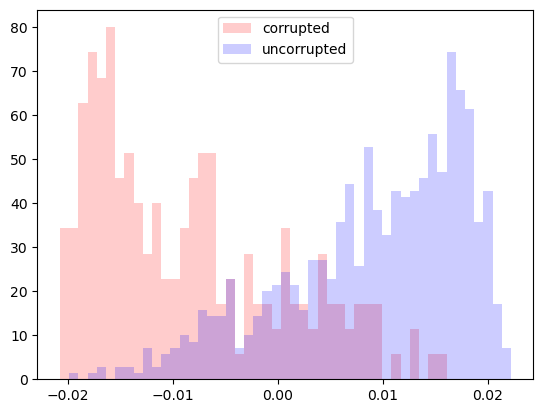

In [7]:
plt.figure() 
bins = np.linspace(vals_dvgs.min(), vals_dvgs.max(), 50)
plt.hist(vals_dvgs[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvgs[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

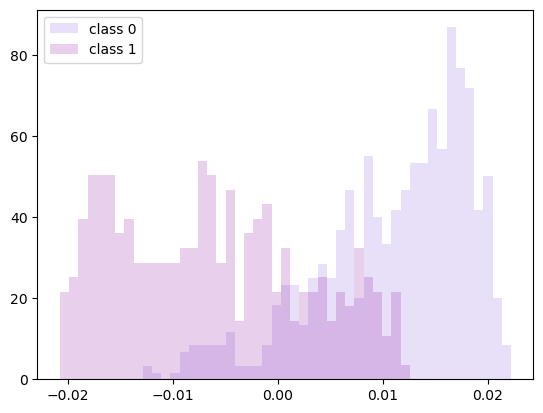

In [8]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_dvgs.min(), vals_dvgs.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=3)
    plt.hist(vals_dvgs[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

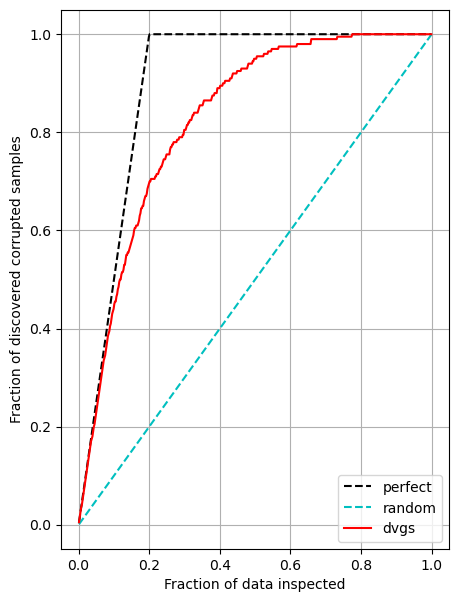

In [9]:
pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Data Shapley (dshap)

[arxiv](https://arxiv.org/abs/1904.02868)  
[proceedings](https://proceedings.mlr.press/v97/ghorbani19c/ghorbani19c.pdf)  
[github](https://github.com/amiratag/DataShapley) 

```
@inproceedings{ghorbani2019data,
  title={Data Shapley: Equitable Valuation of Data for Machine Learning},
  author={Ghorbani, Amirata and Zou, James},
  booktitle={International Conference on Machine Learning},
  pages={2242--2251},
  year={2019}
}
```

In [172]:
CEL = torch.nn.CrossEntropyLoss() 

dshap = DShap.DShap(model           = model, 
                    crit            = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)),
                    x_train         = x_train,
                    y_train         = y_train,
                    x_valid         = x_valid,
                    y_valid         = y_valid,
                    perf_metric     = lambda y, yhat: roc_auc_score(y, yhat[:, 1]),
                    epochs          = 100,
                    tol             = 0.03,
                    optim           = torch.optim.Adam,
                    lr              = 1e-3,
                    verbose         = True)

tic = time.time() 
vals_shap = dshap.TMC(max_iterations=500, min_iterations=50, use_cuda=True, T=5, stopping_criteria=0.999)

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

v0 (null model): 0.5149
vD (all data): 0.8685

starting Data Shapley TMC...
iter: 119 || max j: 371 || max vj: 0.8490 || rank_corr: 0.9990
MC stopping criteria met. running avg rank correlation: 0.9990

time elapsed: 347.52 min


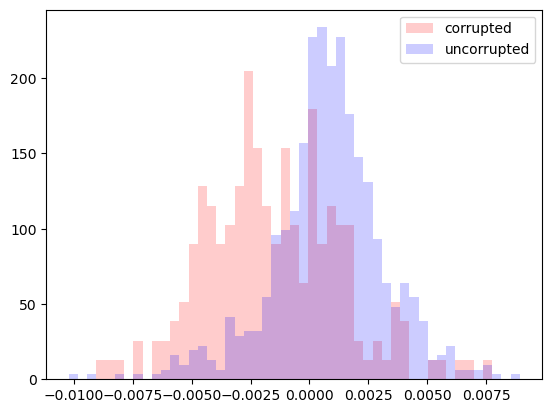

In [173]:
plt.figure() 
bins = np.linspace(vals_shap.min(), vals_shap.max(), 50)
plt.hist(vals_shap[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_shap[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

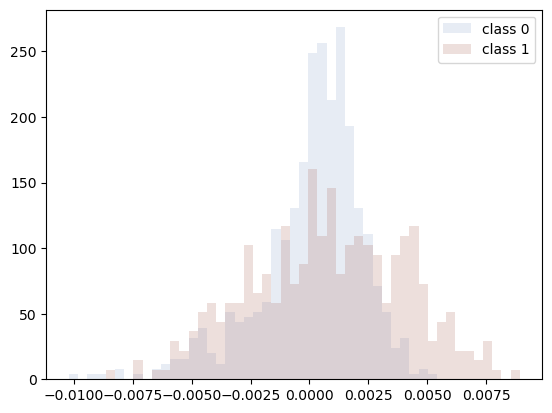

In [174]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_shap.min(), vals_shap.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_shap[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

(1000,)


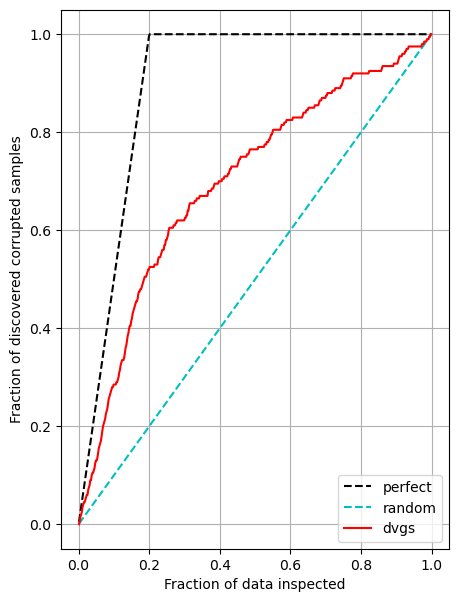

In [175]:
pk, shap_corr, p_perfect, p_random = get_corruption_scores(vals_shap, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, shap_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Leave-one-out (LOO)



In [176]:
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)) 
metric = lambda y,yhat: roc_auc_score(y, yhat[:, 1])  

loo = LOO(x_train           = x_train,
          y_train           = y_train,
          x_valid           = x_valid,
          y_valid           = y_valid,
          model             = model,
          metric            = metric,
          crit              = crit, 
          optim             = torch.optim.Adam, 
          epochs            = 200, 
          lr                = 1e-4,
          batch_size        = 250, 
          use_cuda          = True, 
          verbose           = True, 
          baseline_repl     = 10,
          n_repl            = 1)

print()  

loo_values = loo.run()
vals_loo = np.array(loo_values)

baseline performance: 0.857 +/- 0.001



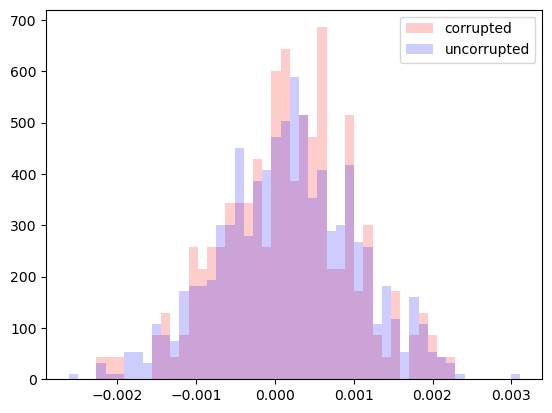

In [177]:
plt.figure() 
bins = np.linspace(vals_loo.min(), vals_loo.max(), 50)
plt.hist(vals_loo[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_loo[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

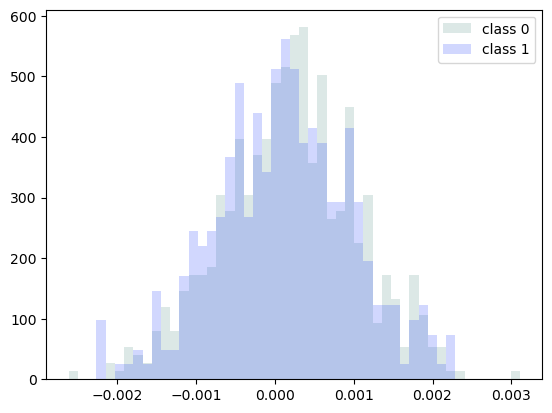

In [178]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_loo.min(), vals_loo.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_loo[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

(1000,)


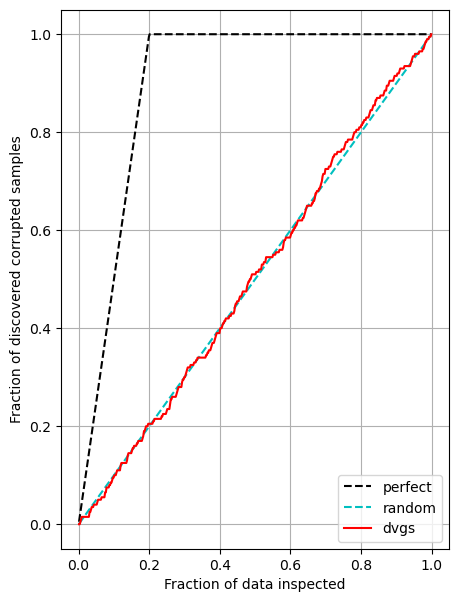

In [179]:
pk, loo_corr, p_perfect, p_random = get_corruption_scores(vals_loo, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, loo_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

# Data Valuation with Reinforcement Learning (DVRL)



In [11]:
#pred = LogisticRegression(108, 2) 

pred = copy.deepcopy(model) 
#pred.reset_parameters()

est = NNEst(xin=108, yin=4, y_cat_dim=100, out_channels=1, num_layers=3, hidden_channels=200, norm=False, dropout=0.0, bias=True, act=torch.nn.ReLU)
#est = EmbEst(num_samples=x_train.shape[0])

dvrl = DVRL(x_train             = x_train,
            y_train             = y_train,
            x_valid             = x_valid,
            y_valid             = y_valid,
            predictor           = pred, 
            estimator           = est, 
            problem             = 'classification',
            include_marginal    = True)

print()

# pretraining...
#dvrl.fit(dvrl.predictor, dvrl.x_train, dvrl.y_train, crit=lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), batch_size=256, lr=1e-4, epochs=500, use_cuda=True)

tic = time.time() 
vals_dvrl = dvrl.run(perf_metric            = 'auroc', 
                     crit_pred              = lambda x,y: torch.nn.functional.cross_entropy(x, y.squeeze(1).type(torch.long)), 
                     outer_iter             = 1000, 
                     inner_iter             = 200, 
                     outer_batch            = 1000, 
                     inner_batch            = 250, 
                     estim_lr               = 1e-2, 
                     pred_lr                = 1e-4, 
                     moving_average_window  = 50,
                     entropy_beta           = 0.1, 
                     entropy_decay          = 1.,
                     fix_baseline           = True,
                     noise_labels           = endog_noise,
                     use_cuda               = False)

vals_dvrl = vals_dvrl.detach().numpy().ravel()

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')      


pretraining `ori_model` and `val_model` 
4/4


KeyboardInterrupt: 

In [1]:
plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)
plt.hist(vals_dvrl[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvrl[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [2]:
# data vals ~ class ? 

classes = list(np.sort(np.unique(y_train.detach().numpy()))) 

plt.figure() 
bins = np.linspace(vals_dvrl.min(), vals_dvrl.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_dvrl[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

NameError: name 'np' is not defined

In [3]:
pk, dvrl_corr, p_perfect, p_random = get_corruption_scores(vals_dvrl, endog_noise.nonzero()[0], train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvrl_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

NameError: name 'get_corruption_scores' is not defined